<a href="https://colab.research.google.com/github/vervainalthor/Coursera_capstone/blob/master/Battle_of_the_neighbourhood_opening_a_salad_bar_in_Toronto_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Battle of Neighborhoods — Coursera Capstone Project

# THE BUSINESS PROBLEM
### What is the best location for salad bar in Toronto ?
### In what Neighborhood should I open a salad bar to have the best chance of becoming profitable as soon as possible?


Bright and bustling, Toronto is a cosmopolitan city whose residents have roots across the globe. Art, food, beaches, nightlife – in Toronto, you’ve got it all. It is a destination for young talent from all over canada and the globe.

The main objective of this project is to pick a profitable location for a new low calorie salad bar that focuses on young fitness enthusiasts that already show an existing commitement to fitness

# Data Section
For this project we need the following data:


1. Toronto city data that contains Borough, Neighborhoods along with there latitudes and longitudes

    Data Source: Toronto location data frame from the previous week that was devloped using the toronto postal code wiki page and the geospatial data csv
Description: This data set contains the required information. And we will use this data set to explore various neighborhoods of Toronto.


2. Gyms in toronto.
Since our target market is fitness lovers, setting up the buisnessn in areas saturated with fitness centres will increase the likely hood of attracting the right clientel

    Data Source: Foursquare API
Description: By using this API we will get all  Gyms in the city and narrow down neighbourhoods with the highest number of gyms and lowest number.

# Approach
## Collect the Toronto city data from the previous week's notebook.
Using Foursquare API we will get all venues for each borough then narrow down to neighbourhoods in the borough with the highest gyms .


## Data Visualization and some statistical analysis.
Analyzing using Clustering (Specially K-Means):
1. Find the best value of K
2. Visualize the neighborhoods with a number of Gyms Restaurants.
Compare the Neighborhoods to Find the Best Place for Starting up a Restaurant.
Inference From these Results and related Conclusions


### GATHERING TORONTO LOCATION DATA
  I Used beautiful soup to scrape the table from the wiki page 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
 and arranged it into the desired format, the code used is derived from the sample code in the assignemnt page

In [1]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
pd.set_option("display.precision", 2)


In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
print(url)
print(result.status_code)
print(result.headers)

https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
200
{'Date': 'Wed, 14 Apr 2021 01:40:43 GMT', 'Server': 'mw1369.eqiad.wmnet', 'X-Content-Type-Options': 'nosniff', 'P3p': 'CP="See https://en.wikipedia.org/wiki/Special:CentralAutoLogin/P3P for more info."', 'Content-Language': 'en', 'Vary': 'Accept-Encoding,Cookie,Authorization', 'X-Request-Id': '1cfdf9d4-a60a-4503-892c-6ac37177795f', 'Last-Modified': 'Wed, 14 Apr 2021 01:39:36 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Content-Encoding': 'gzip', 'Age': '58301', 'X-Cache': 'cp2041 hit, cp2027 hit/2', 'X-Cache-Status': 'hit-front', 'Server-Timing': 'cache;desc="hit-front", host;desc="cp2027"', 'Strict-Transport-Security': 'max-age=106384710; includeSubDomains; preload', 'Report-To': '{ "group": "wm_nel", "max_age": 86400, "endpoints": [{ "url": "https://intake-logging.wikimedia.org/v1/events?stream=w3c.reportingapi.network_error&schema_uri=/w3c/reportingapi/network_error/1.0.0" }] }', 'NEL': '{ "report_to": "wm_nel

In [3]:
soup = BeautifulSoup(result.content, 'html.parser')
table = soup.find('table')
trs = table.find_all('tr')
rows = []
for tr in trs:
    i = tr.find_all('td')
    if i:
        rows.append(i)
        
lst = []
for row in rows:
    postalcode = row[0].text.rstrip()
    borough = row[1].text.rstrip()
    neighborhood = row[2].text.rstrip()
    if borough != 'Not assigned':
        if neighborhood == 'Not assigned':
            neighborhood = borough
        lst.append([postalcode, borough, neighborhood])

In [4]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

In [5]:
df=pd.DataFrame(table_contents)

In [6]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government



NOT ASSIGNED NEIGBOURHOODS HAVE BEEN PASSED OVER WHEN PARSING FROM BEAUTIFUL SOUP

 # Adding coordinates to the location data
 Using the Geospatial data provided by coursera

First i orderded the dataframe grouped by postal code and alphabetically like in the csv file

In [7]:
df = df.groupby('PostalCode').agg(
    {
        'Borough':'first', 
        'Neighborhood': ', '.join,}
    ).reset_index()

In [8]:
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [9]:
dfgeo = pd.read_csv("/content/Geospatial_Coordinates.csv")
dfgeo.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)


In [10]:
df2 = pd.merge(df, dfgeo, on="PostalCode", how='left')

checking with row M5G as per the instructions,it alines with it mine will not look exactly like that of the instruction because i used the csv file instead of using google's api but there i no penalties for that

In [11]:
df2.loc[df2['PostalCode'] == 'M5G']

,PostalCode,Borough,Neighborhood,Latitude,Longitude
57,M5G,Downtown Toronto,Central Bay Street,43.66,-79.39


In [12]:
df2.loc[df2['PostalCode'] == 'M5A']

,PostalCode,Borough,Neighborhood,Latitude,Longitude
53,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65,-79.36


In [13]:
df2.head(11)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81,-79.19
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78,-79.16
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76,-79.19
3,M1G,Scarborough,Woburn,43.77,-79.22
4,M1H,Scarborough,Cedarbrae,43.77,-79.24
5,M1J,Scarborough,Scarborough Village,43.74,-79.24
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.73,-79.26
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.71,-79.28
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.72,-79.24
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.69,-79.26


---

---

# GATHERING INFORMATION ON VENUES FROM THE FOURSQUARE API



### Import Required Libraries and setup FourSquare Veriables

In [14]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation


!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


! pip install folium==0.5.0
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


#USING FOURSQUARE API TO GET VENUES

In [15]:
CLIENT_ID = 'HGNQWG01KI0MXQEMQPEBYE1KW2GUR0Z2SKRFTMDNFSZ3QKJI'# Foursquare Id
CLIENT_SECRET = '41TFGS3BEBZQY05LSZUAZMJATVXNGARCVSAMIXA4BLTY0O5I' # Foursquare Secret
VERSION = '20180605' # API version

In [16]:
df2.set_index('PostalCode', inplace = True) 
neighborhood_latitude = df2.loc['M9V']['Latitude']
neighborhood_longitude = df2.loc['M9V']['Longitude']

In [17]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=HGNQWG01KI0MXQEMQPEBYE1KW2GUR0Z2SKRFTMDNFSZ3QKJI&client_secret=41TFGS3BEBZQY05LSZUAZMJATVXNGARCVSAMIXA4BLTY0O5I&v=20180605&ll=43.739416399999996,-79.5884369&radius=500&limit=100'

In [18]:
results = requests.get(url).json()

In [19]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [20]:
venues = results['response']['groups'][0]['items']

In [21]:
nearby_venues = json_normalize(venues) # flatten JSON
nearby_venues

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups
0,e-0-4be58dc4cf200f479154133c-0,0,"[{'summary': 'This spot is popular', 'type': '...",4be58dc4cf200f479154133c,Shoppers Drug Mart,1530 Albion Rd,Albion Mall,43.74,-79.58,"[{'label': 'display', 'lat': 43.741685, 'lng':...",405,M9V 1B4,CA,Etobicoke,ON,Canada,"[1530 Albion Rd (Albion Mall), Etobicoke ON M9...","[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",0,[]
1,e-0-4be70e26cf200f47e334153c-1,0,"[{'summary': 'This spot is popular', 'type': '...",4be70e26cf200f47e334153c,Popeyes Louisiana Kitchen,80-1530 Albion Rd,at Kipling Ave. (Albion Centre),43.74,-79.58,"[{'label': 'display', 'lat': 43.74120870478487...",385,M9V 1B4,CA,Etobicoke,ON,Canada,[80-1530 Albion Rd (at Kipling Ave. (Albion Ce...,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",0,[]
2,e-0-4c633939e1621b8d48842553-2,0,"[{'summary': 'This spot is popular', 'type': '...",4c633939e1621b8d48842553,Subway,"6210 Finch Ave West, Store 103",at Albion Rd.,43.74,-79.59,"[{'label': 'display', 'lat': 43.74264512142215...",372,M9V 0A1,CA,Toronto,ON,Canada,"[6210 Finch Ave West, Store 103 (at Albion Rd....","[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",0,[]
3,e-0-4cd4738cdfb4a1cd4337535c-3,0,"[{'summary': 'This spot is popular', 'type': '...",4cd4738cdfb4a1cd4337535c,The Beer Store,1530 Albion Rd,Near Finch Ave. W.,43.74,-79.58,"[{'label': 'display', 'lat': 43.7416936, 'lng'...",413,M9V 1B4,CA,Etobicoke,ON,Canada,"[1530 Albion Rd (Near Finch Ave. W.), Etobicok...","[{'id': '5370f356bcbc57f1066c94c2', 'name': 'B...",0,[]
4,e-0-4b04a05bf964a520c45522e3-4,0,"[{'summary': 'This spot is popular', 'type': '...",4b04a05bf964a520c45522e3,Sheriff's No Frills,1530 Albion Rd,at Finch Ave. W.,43.74,-79.58,"[{'label': 'display', 'lat': 43.741696, 'lng':...",413,M9V 1B4,CA,Etobicoke,ON,Canada,"[1530 Albion Rd (at Finch Ave. W.), Etobicoke ...","[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",0,[]
5,e-0-4d8ba6910c4e41bdaaf7667f-5,0,"[{'summary': 'This spot is popular', 'type': '...",4d8ba6910c4e41bdaaf7667f,Pizza Pizza,"1530 Albion Road, Unit T25",NaN,43.74,-79.58,"[{'label': 'display', 'lat': 43.74156896801906...",397,M9V 1B4,CA,Etobicoke,ON,Canada,"[1530 Albion Road, Unit T25, Etobicoke ON M9V ...","[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",0,[]
6,e-0-5112b872e4b0c0a78d7bcd27-6,0,"[{'summary': 'This spot is popular', 'type': '...",5112b872e4b0c0a78d7bcd27,Sunny Foodmart,1620 Albion road,Albion Road and Finch Ave,43.74,-79.59,"[{'label': 'display', 'lat': 43.74184023292111...",319,NaN,CA,Toronto,ON,Canada,"[1620 Albion road (Albion Road and Finch Ave),...","[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",0,[]
7,e-0-4c1951d6834e2d7f2d3a2a80-7,0,"[{'summary': 'This spot is popular', 'type': '...",4c1951d6834e2d7f2d3a2a80,McDonald's,"1530 Albion Road, Unit F-1",NaN,43.74,-79.58,"[{'label': 'display', 'lat': 43.7417571, 'lng'...",427,M9V 1B4,CA,Toronto,ON,Canada,"[1530 Albion Road, Unit F-1, Toronto ON M9V 1B...","[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",0,[]
8,e-0-4ce971bff8653704e40db7c4-8,0,"[{'summary': 'This spot is popular', 'type': '...",4ce971bff8653704e40db7c4,LCBO,Albion Mall,1530 Albion Rd,43.74,-79.58,"[{'label': 'display', 'lat': 43.74150752194671...",392,M9V 1B4,CA,Toronto,ON,Canada,"[Albion Mall (1530 Albion Rd), Toronto ON M9V ...","[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",0,[]


In [22]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Shoppers Drug Mart,Pharmacy,43.74,-79.58
1,Popeyes Louisiana Kitchen,Fried Chicken Joint,43.74,-79.58
2,Subway,Sandwich Place,43.74,-79.59
3,The Beer Store,Beer Store,43.74,-79.58
4,Sheriff's No Frills,Grocery Store,43.74,-79.58


In [23]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

9 venues were returned by Foursquare.


### Getting nearby venues
Using helper functions most of the code is derived from the foursquare API lap

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)                   

In [25]:
df2

,Borough,Neighborhood,Latitude,Longitude
PostalCode,,,,
M1B,Scarborough,"Malvern, Rouge",43.81,-79.19
M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78,-79.16
M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76,-79.19
M1G,Scarborough,Woburn,43.77,-79.22
M1H,Scarborough,Cedarbrae,43.77,-79.24
...,...,...,...,...
M9N,York,Weston,43.71,-79.52
M9P,Etobicoke,Westmount,43.70,-79.53
M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.69,-79.55


In [26]:
venues = getNearbyVenues(names=df2['Neighborhood'],latitudes=df2['Latitude'],longitudes=df2['Longitude'])

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Don Mills South
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
The Danforth  East
The Danforth West, Riverdale


In [27]:
print(venues.shape)
venues.head()

(2114, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.81,-79.19,Wendy’s,43.81,-79.20,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.78,-79.16,Chris Effects Painting,43.78,-79.16,Construction & Landscaping
2,"Rouge Hill, Port Union, Highland Creek",43.78,-79.16,Royal Canadian Legion,43.78,-79.16,Bar
3,"Guildwood, Morningside, West Hill",43.76,-79.19,RBC Royal Bank,43.77,-79.19,Bank
4,"Guildwood, Morningside, West Hill",43.76,-79.19,G & G Electronics,43.77,-79.19,Electronics Store


In [28]:
venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",24,24,24,24,24,24
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
...,...,...,...,...,...,...
Willowdale West,4,4,4,4,4,4
"Willowdale, Newtonbrook",2,2,2,2,2,2
Woburn,4,4,4,4,4,4


In [29]:
print('There are {} unique categories.'.format(len(venues['Venue Category'].unique())))

There are 274 unique categories.


In [30]:
#one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

onehot.head()

,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,...,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
onehot.shape

(2114, 274)

In [32]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped

,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,...,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0
95,"Willowdale, Newtonbrook",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
96,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [33]:
grouped.shape

(99, 274)

# FOCUSING ON GYM VENUES
I extracted the coloumns 'Neigborhood' and 'gym' in order to base my analysis and clustering on the gym availability

In [34]:
grouped2 = grouped[['Neighborhood','Gym']].copy()

In [35]:
grouped2.head(1)

,Neighborhood,Gym
0,Agincourt,0.0


In [36]:
grouped2.sort_values(by='Gym', ascending=False, inplace=True)
grouped2.head()

,Neighborhood,Gym
95,"Willowdale, Newtonbrook",0.50
21,Don Mills North,0.25
1,"Alderwood, Long Branch",0.14
22,Don Mills South,0.10
58,"New Toronto, Mimico South, Humber Bay Shores",0.08


# we found that willowdale,Newton brook was the neighbourhood with the most gyms and the most likely place to locate a low calorie salad bar with a active gym going population

# lets still find other neighbourhoods like Willowdale to make room for possible franchising 

#picking the best k value for clustering

Initialization complete
Iteration  0, inertia 0.375
Iteration  1, inertia 0.347
Converged at iteration 1: center shift 0.000000e+00 within tolerance 3.506871e-07
Initialization complete
Iteration  0, inertia 0.375
Iteration  1, inertia 0.347
Converged at iteration 1: center shift 0.000000e+00 within tolerance 3.506871e-07
Initialization complete
Iteration  0, inertia 0.375
Iteration  1, inertia 0.347
Converged at iteration 1: center shift 0.000000e+00 within tolerance 3.506871e-07
Initialization complete
Iteration  0, inertia 0.375
Iteration  1, inertia 0.347
Converged at iteration 1: center shift 0.000000e+00 within tolerance 3.506871e-07
Initialization complete
Iteration  0, inertia 0.375
Iteration  1, inertia 0.347
Converged at iteration 1: center shift 0.000000e+00 within tolerance 3.506871e-07
Initialization complete
Iteration  0, inertia 0.375
Iteration  1, inertia 0.347
Converged at iteration 1: center shift 0.000000e+00 within tolerance 3.506871e-07
Initialization complete
Iter

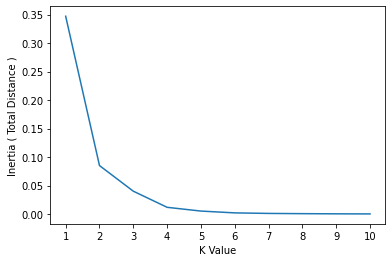

In [37]:
#IMPORT LIBRARIES
import numpy as np
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt
x=grouped2.drop('Neighborhood', 1)

#Create a function that calculates Inertia for n times
#We will sweep through 1 to n to find the optimal cluster number
def cluster_variance(n):
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(1,n+1)]
    for i in range(1,n+1):
        variance=0
        model=KMeans(n_clusters=i,random_state=82,verbose=2).fit(x)
        kmeans.append(model)
        variances.append(model.inertia_)
        
    return variances,K,n
variances,K,n=cluster_variance(10)
plt.plot(K,variances)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(1,n+1)])
plt.show()

# CREATING CLUSTERS

In [57]:
# for K-means clustering
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 4

grouped_clustering = grouped2.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 2, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [58]:
df2 = df2.drop_duplicates()
df2.shape

(103, 4)

# CREATING A DATA SET SUITED FOR A MAP 
By merging the encoded data set to our original data set with cordinates

In [60]:
# add clustering labels
merged= df2
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged = merged.join(grouped2.set_index('Neighborhood'), on='Neighborhood')


In [61]:
merged.shape


(103, 5)

In [62]:
merged.head()

,Borough,Neighborhood,Latitude,Longitude,Gym
PostalCode,,,,,
M1B,Scarborough,"Malvern, Rouge",43.81,-79.19,0.0
M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78,-79.16,0.0
M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76,-79.19,0.0
M1G,Scarborough,Woburn,43.77,-79.22,0.0
M1H,Scarborough,Cedarbrae,43.77,-79.24,0.0


In [43]:
sorted(merged)

['Borough', 'Gym', 'Latitude', 'Longitude', 'Neighborhood']

In [63]:
bool_series = pd.isnull(merged['Gym'])
merged[bool_series]

,Borough,Neighborhood,Latitude,Longitude,Gym
PostalCode,,,,,
M1X,Scarborough,Upper Rouge,43.84,-79.21,NaN
M2L,North York,"York Mills, Silver Hills",43.76,-79.37,NaN
M9A,Etobicoke,Islington Avenue,43.67,-79.53,NaN
M9B,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.65,-79.55,NaN


some neighbourhoods were not represented in foursquare there missing values have to be taken out

In [65]:
merged.dropna(inplace= True)

In [66]:
merged.shape

(99, 5)

In [67]:
# add clustering labels

merged['Cluster_Labels'] = kmeans.labels_


In [68]:
merged['Cluster_Labels'] = merged.Cluster_Labels.astype(int)

In [69]:
merged.head(1)

,Borough,Neighborhood,Latitude,Longitude,Gym,Cluster_Labels
PostalCode,,,,,,
M1B,Scarborough,"Malvern, Rouge",43.81,-79.19,0.0,1


In [70]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
latitude_toronto = location.latitude
longitude_toronto = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude_toronto, longitude_toronto))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


# HIGHLIGHTING THE CLUSTERS IN TORONTO ON THE FOLIUM MAP

In [71]:
import matplotlib.cm as cm
import matplotlib.colors as colors
map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=10)
x = np.arange(kclusters)
ys=[i+x+(i*x)**2 for i in range(kclusters)]
colors_array=cm.rainbow(np.linspace(0,1,len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#add markers
markers_colors=[]
for lat, lng , Neighborhood , cluster in zip(merged['Latitude'],merged['Longitude'],merged['Neighborhood'],merged['Cluster_Labels']):
    label = '{}, {}'.format(Neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radiesu=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)

    
map_toronto

### Examine clusters

In [72]:
merged.sort_values(by='Gym', ascending=False, inplace=True)


In [73]:
#cluster 1
merged.loc[merged['Cluster_Labels'] == 0,]

,Borough,Neighborhood,Latitude,Longitude,Gym,Cluster_Labels
PostalCode,,,,,,
M1W,Scarborough,"Steeles West, L'Amoreaux West",43.80,-79.32,0.0,0
M1V,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.82,-79.28,0.0,0
M1T,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",43.78,-79.30,0.0,0
M1S,Scarborough,Agincourt,43.79,-79.26,0.0,0
M1R,Scarborough,"Wexford, Maryvale",43.75,-79.30,0.0,0
M1P,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",43.76,-79.27,0.0,0
M1N,Scarborough,"Birch Cliff, Cliffside West",43.69,-79.26,0.0,0
M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.72,-79.24,0.0,0
M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.71,-79.28,0.0,0


In [74]:
#cluster 2
merged.loc[merged['Cluster_Labels'] == 1,]

,Borough,Neighborhood,Latitude,Longitude,Gym,Cluster_Labels
PostalCode,,,,,,
M1B,Scarborough,"Malvern, Rouge",43.81,-79.19,0.0,1


In [75]:
#cluster 3
merged.loc[merged['Cluster_Labels'] == 2,]

,Borough,Neighborhood,Latitude,Longitude,Gym,Cluster_Labels
PostalCode,,,,,,
M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76,-79.19,0.0,2
M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78,-79.16,0.0,2


In [76]:
#cluster 4
merged.loc[merged['Cluster_Labels'] == 3,]

,Borough,Neighborhood,Latitude,Longitude,Gym,Cluster_Labels
PostalCode,,,,,,
M2M,North York,"Willowdale, Newtonbrook",43.79,-79.41,0.50,3
M3B,North York,Don Mills North,43.75,-79.35,0.25,3
M8W,Etobicoke,"Alderwood, Long Branch",43.60,-79.54,0.14,3
M3C,North York,Don Mills South,43.73,-79.34,0.10,3
M8V,Etobicoke,"New Toronto, Mimico South, Humber Bay Shores",43.61,-79.50,0.08,3
...,...,...,...,...,...,...
M3N,North York,Downsview Northwest,43.76,-79.52,0.00,3
M3M,North York,Downsview Central,43.73,-79.50,0.00,3
M3L,North York,Downsview West,43.74,-79.51,0.00,3


# CONCLUSION
The client is best advised to open their first venue in Willowdale, Newtonbrook, most of toronto's neighbourhood appear to have a high density of gyms and the client is advised to open venues in order of gym frequencies in cluster 4 

#Oppurtunity for improvement

More parameters that would have made an impact

1. The inclusion of gym adjacent venues such as yoga studios and sports centres
2. The study of similar businesses such as other low calories salad bars and juice places 
3. focusing on areas that have a combination of low density of similar venues (other healthy food options) and high density of Clientelle venues such as (gyms,yoga studios, sports centres)